# Quantum Anomaly Dataset

Author : [Nishantak Panigrahi](https://github.com/nishantak)

---

> Like detecting faulty sensor readings. Except now, the "samples" are quantum states.

A quantum anomaly detection dataset consists of:
- Quantum states (represented as vectors, circuits, or density matrices),

- Some of which are "normal" (i.e., typical behavior),

- And others are "anomalous" (i.e., rare, unusual, faulty, or unexpected quantum states. Such as random gate flip, or faulty entanglements).

e.g. proton collision events at the LHC

In [1]:
import os, json

import numpy as onp
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as np
from qutip import Qobj, ptrace, expect, sigmax, sigmay, sigmaz

In [2]:
# Configuration
n_qubits = 4
n_samples = 2048
frac_anomaly = 0.35

# shots = None  # full statevector | expectation values from wavefunction (ideal); not sampled from distribution (like in real experiments)
dev = qml.device("default.mixed", wires=n_qubits) # for noise

onp.random.seed(42)

## Dataset Generation

We are simulating a quantum sensor like in a quantum radar, communication channel or imaging, that:
- Normal operation: quantum states generated by a clean parameterized circuit.

- Occasional Anomalies: induced through:
    - Decoherence (simulated by adding noise)
    - Bit-flip errors
    - Gate drift (slightly altered rotation angles).

Each data point includes:
- Probability amplitudes of computational basis states

- Bloch vectors of individual qubits states

- A label indicating if it's normal (0) or anomalous (1)

- The type of anomaly injected  

Sensor

(<Figure size 900x500 with 1 Axes>, <Axes: >)

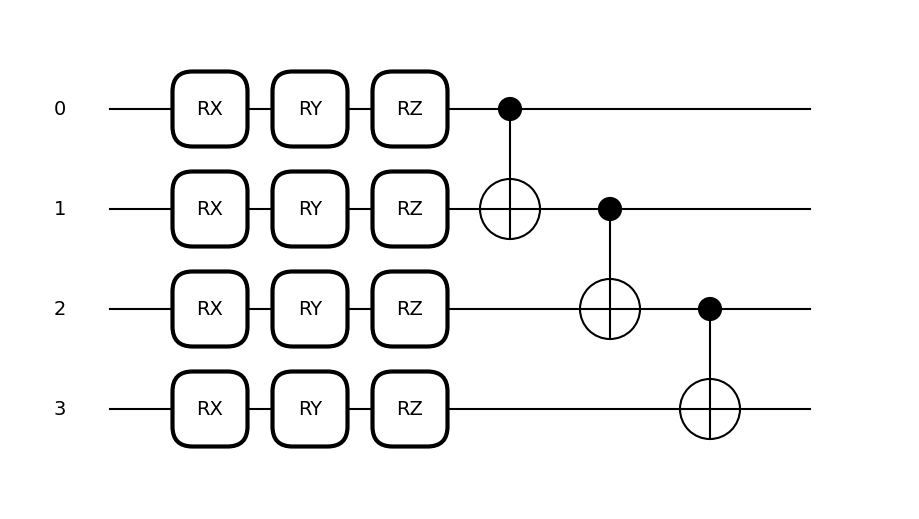

In [3]:
# Define quantum sensor circuit
def quantum_sensor(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    # Linear Chain Entanglement (n−1 style) [Matches hardware with linear connectivity like some trapped-ion or superconducting qubit layouts]
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])
        

# Define anomalies
def sensor_anomaly(anomaly_type):
    if anomaly_type == "decoherence":
        for i in range(n_qubits):
            qml.AmplitudeDamping(0.35, wires=i)  # Simulates T1 relaxation (|1⟩ -> |0⟩) with 30% probability | Close to actual hardware decoherence

    elif anomaly_type == "depolarization":
        for i in range(n_qubits):
            qml.DepolarizingChannel(1, wires=i)  # 30% chance to randomly apply X, Y, or Z (Pauli) noise | Moderate artificial noise close to actual hardware depolarization

    elif anomaly_type == "bit_flip":
        qml.BitFlip(p=1.0, wires=0)  # Always flips qubit 0 (X gate with 100% probability)

    elif anomaly_type == "gate_drift":
        qml.RX(1.5, wires=0)  # Simulates drift in RX gate angle on qubit 0 by +1.5 radians

    elif anomaly_type == "crosstalk":
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i, i+1])  # Adds unintended entanglement between neighboring qubits (hardware crosstalk)
            
qml.draw_mpl(quantum_sensor)(np.random.rand(n_qubits, 3))

A quantum state can be descibed by: 
- A state vector (or wavefunction) (usually for pure states, written as |$\psi$⟩.)

- A density matrix: a more general way to represent quantum states, especially mixed states (which include noise or uncertainty).

Density Matrix:

If the state is pure and written as

$$
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle
$$

then

$$
\rho = |\psi\rangle \langle \psi| = \begin{pmatrix} |\alpha|^2 & \alpha \beta^* \\ \alpha^* \beta & |\beta|^2 \end{pmatrix}
$$

* Diagonal: probabilities $|\alpha|^2, |\beta|^2$.
* Off-diagonal: $\alpha \beta^*$ and $\alpha^* \beta$, describing *how the two states overlap and interfere*.


What are the off-diagonals: $\rho_{01}$ and $\rho_{10}$?

* They represent **coherences**, which quantify how much the quantum state has *phase correlations* between $|0\rangle$ and $|1\rangle$.

* These terms are complex numbers and encode the **quantum interference** effects.

* Without coherences, the density matrix would be diagonal, representing a classical probabilistic mixture without quantum interference.

Consider the pure (no noise, $Tr(\rho^2)=1$) single qubit superposition state:

$$
|\psi\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}
$$

Density matrix:

$$
\rho = \frac{1}{2} \begin{pmatrix} 1 & 1 \\ 1 & 1 \end{pmatrix}
$$

* Diagonal: both 0.5 -> equal probabilities of finding in state |0> and state |1>.
* Off-diagonal: 0.5 -> strong coherence (maximum, since equal to diagonal elements), indicating strong quantum effects like superposition and interference. E.g. Measuring in |+> basis deterministically gives |+> output due to phase relationship.

If the off-diagonal terms decay to zero (e.g., due to decoherence), the state becomes

$$
\rho = \begin{pmatrix} 0.5 & 0 \\ 0 & 0.5 \end{pmatrix}
$$

which is a equal mixture of $|0\rangle$ and $|1\rangle$ but with no coherence, i.e even measuring in other bases like |+> would give random output because no phase relationship.

In [4]:
# Quantum circuit
@qml.qnode(dev)
def run_circuit(params, anomaly=False, anomaly_type=None):
    quantum_sensor(params)
    if anomaly:
        sensor_anomaly(anomaly_type)
    return qml.state()  # Full density matrix for mixed states

The **Bloch vector** $\vec{r}$ of a single-qubit quantum state $\rho$ is defined by the expectation values of the Pauli matrices:

$$
r_i = \langle \sigma_i \rangle = \operatorname{Re} \left[ \operatorname{Tr}(\rho \, \sigma_i) \right] = \operatorname{Re}\left[ \texttt{expect}(\sigma_i, \rho) \right]
$$


In [5]:
# UTILITY: Generate Block Vector using QuTiP
def compute_bloch_vector(rho):
    return np.array([
        np.real(expect(sigmax(), rho)),
        np.real(expect(sigmay(), rho)),
        np.real(expect(sigmaz(), rho)),
    ])


# UTILITY: Extract Features
def extract_features(density_matrix):
    state = Qobj(density_matrix, dims=[[2]*n_qubits, [2]*n_qubits])
    probs = np.real(np.diag(state.full()))  # Diagonal = measurement probabilities
    blochs = [compute_bloch_vector(ptrace(state, i)) for i in range(n_qubits)]
    return probs, np.array(blochs)

In [6]:
# Dataset generation
def generate_dataset(n=128, anomaly_fraction=0.3, path="anomaly_detection_dataset"):
    os.makedirs(os.path.join(path, "normal"), exist_ok=True)
    os.makedirs(os.path.join(path, "anomaly"), exist_ok=True)

    num_anomalies = int(n * anomaly_fraction)
    num_normal = n - num_anomalies

    # Generate normal samples
    for i in range(num_normal):
        params = onp.random.uniform(0, 2*np.pi, size=(n_qubits, 3))
        state = run_circuit(params, anomaly=False)
        probs, bloch = extract_features(state)
        normal_sample = {
            "probs": probs.tolist(),
            "bloch": bloch.tolist(),
            "label": 0,
            "anomaly_type": "None"
        }
        with open(os.path.join(path, "normal", f"sample_{i:03d}.json"), "w") as f:
            json.dump(normal_sample, f)

    # Generate anomalous samples
    for i in range(num_anomalies):
        params = onp.random.uniform(0, 2*np.pi, size=(n_qubits, 3))
        anomaly_type = onp.random.choice([
            "decoherence", # for best demo keep only decoherence
            # "depolarization", 
            # "bit_flip", 
            # "gate_drift", 
            # "crosstalk"
        ])
        state_anom = run_circuit(params, anomaly=True, anomaly_type=anomaly_type)
        probs_anom, bloch_anom = extract_features(state_anom)
        anom_sample = {
            "probs": probs_anom.tolist(),
            "bloch": bloch_anom.tolist(),
            "label": 1,
            "anomaly_type": anomaly_type
        }
        with open(os.path.join(path, "anomaly", f"sample_{i:03d}.json"), "w") as f:
            json.dump(anom_sample, f)

            
# generate_dataset(n=n_samples, anomaly_fraction=frac_anomaly)

Label distribution: Counter({0: 1332, 1: 716})
Anomaly types: Counter({'None': 1332, 'decoherence': 716})


C:\Users\89\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\89\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


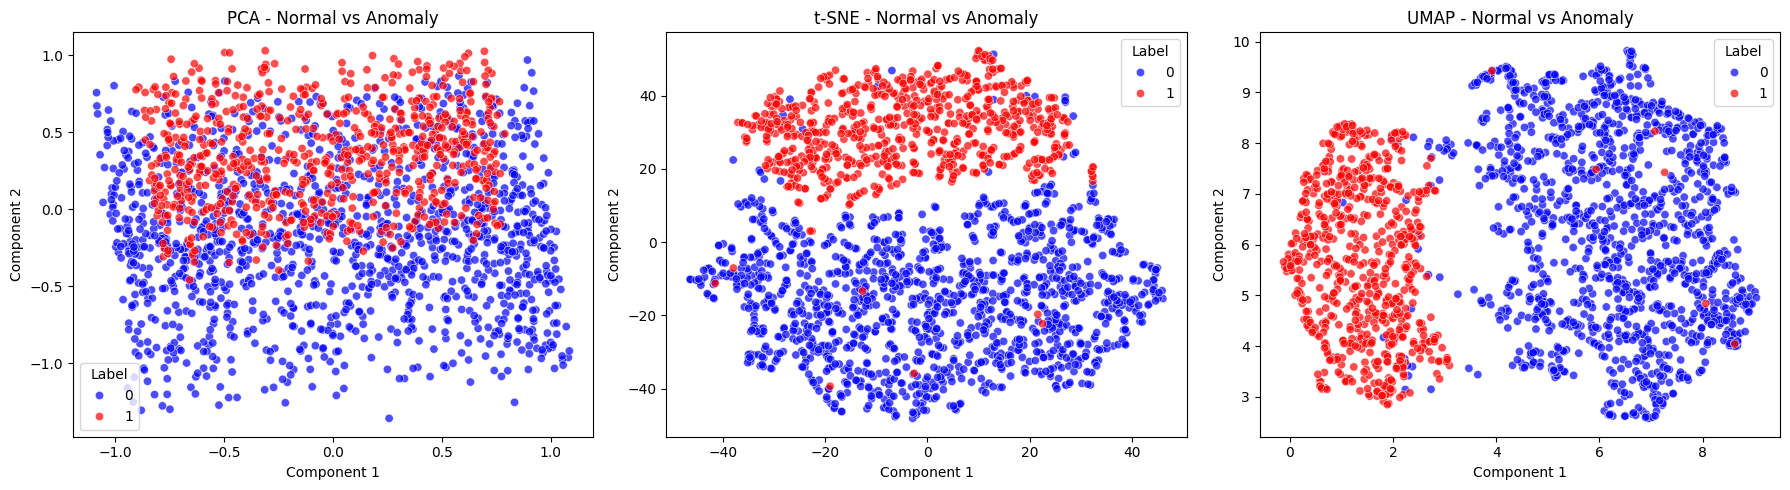

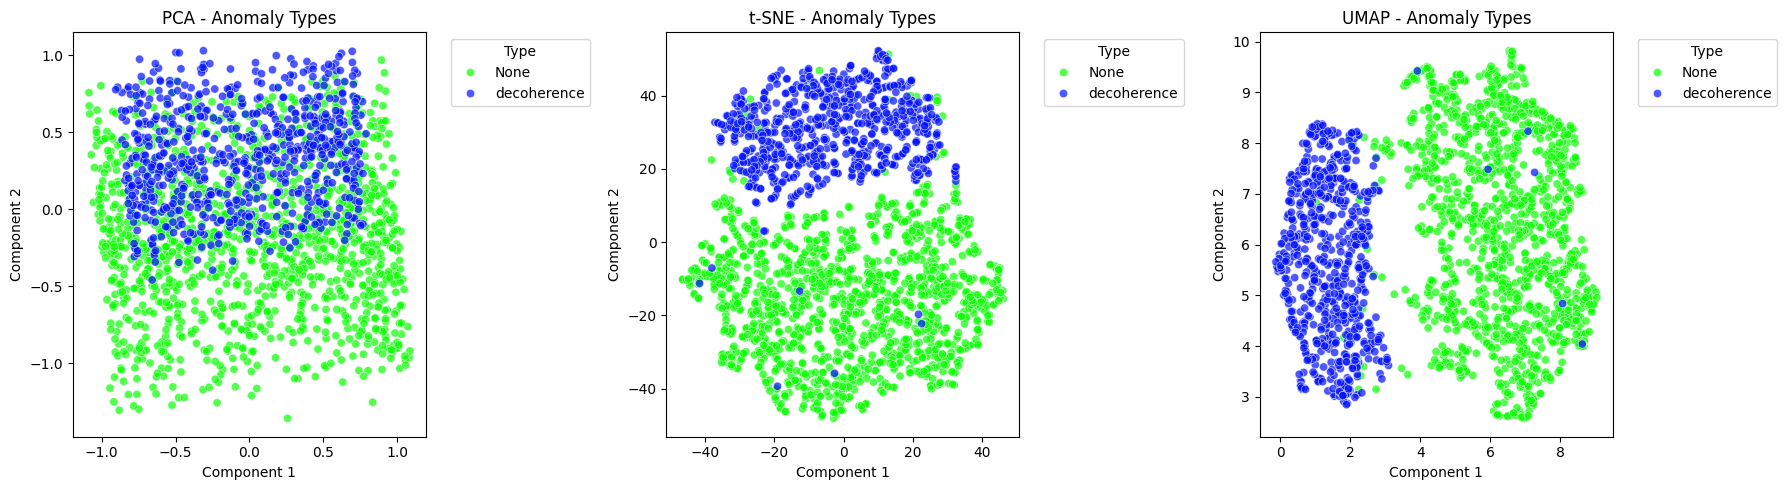

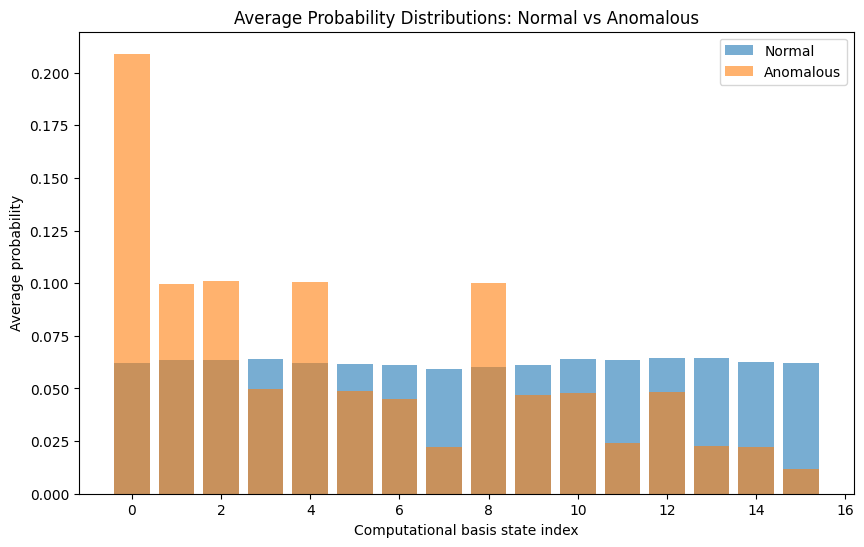

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import json, os, glob, collections

def load_dataset(path="anomaly_detection_dataset"):
    def load_json_files(folder):
        files = glob.glob(os.path.join(folder, "*.json"))
        data = []
        for file in files:
            with open(file, "r") as f:
                data.append(json.load(f))
        return data

    normal_data = load_json_files(os.path.join(path, "normal"))
    anomaly_data = load_json_files(os.path.join(path, "anomaly"))
    return normal_data + anomaly_data

def dataset_to_numpy(data):
    probs = np.array([d["probs"] for d in data])
    blochs = np.array([d["bloch"] for d in data])
    labels = np.array([d["label"] for d in data])
    types = np.array([d.get("anomaly_type", "normal") for d in data])
    return probs, blochs, labels, types

data = load_dataset()
probs, blochs, labels, types = dataset_to_numpy(data)
bloch_flat = blochs.reshape(len(blochs), -1)

# --- Stats ---
print("Label distribution:", collections.Counter(labels))
print("Anomaly types:", collections.Counter(types))


pca = PCA(n_components=2).fit_transform(bloch_flat) # Linear projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(bloch_flat) # Non-linear projection
umap_embed = umap.UMAP(n_components=2, random_state=42).fit_transform(bloch_flat) # Manifold projection

# --- Plot: LABEL (normal vs anomaly) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['PCA', 't-SNE', 'UMAP']
embeddings = [pca, tsne, umap_embed]

for ax, emb, title in zip(axes, embeddings, titles):
    sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=labels, palette=["blue", "red"], alpha=0.7, ax=ax)
    ax.set_title(f"{title} - Normal vs Anomaly")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(title="Label")

plt.tight_layout()
plt.show()

# --- Plot: ANOMALY TYPE ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
unique_types = np.unique(types)
palette = sns.color_palette("hsv", len(unique_types))
titles = ['PCA', 't-SNE', 'UMAP']

for ax, emb, title in zip(axes, embeddings, titles):
    sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=types, palette=palette, alpha=0.7, ax=ax)
    ax.set_title(f"{title} - Anomaly Types")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(title="Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Separate probs by label
probs_normal = probs[labels == 0]
probs_anomaly = probs[labels == 1]

# Average probability distribution per class
mean_probs_normal = np.mean(probs_normal, axis=0)
mean_probs_anomaly = np.mean(probs_anomaly, axis=0)

# Plot average probability distributions
plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_probs_normal)), mean_probs_normal, alpha=0.6, label="Normal")
plt.bar(range(len(mean_probs_anomaly)), mean_probs_anomaly, alpha=0.6, label="Anomalous")
plt.xlabel("Computational basis state index")
plt.ylabel("Average probability")
plt.title("Average Probability Distributions: Normal vs Anomalous")
plt.legend()
plt.show()

# Autoencoder

> If we can recreate the original data after compressing it (reducing dimensionality), we must have captured the most essential features.

Type of neural network architecture used to learn a compressed representation of input data. It tries to reconstruct its input after passing it through a dimensionality reducer, thereby learning latent space representations (essential features).

Suppose we have a high-resolution photo. We compress it and then decompress it. If it looks good, the compression was effective --> the decoder learnt how to _“fill in the blanks.”_

In the autoencoder:
- Encoder learns to remove redundant information.

- Decoder learns to reconstruct from a minimal set of essential features.

### Mathematical Formulation

Let:

* $\mathbf{x} \in \mathbb{R}^n$ be the input data (in n dimensions)

* $f_\theta(\cdot)$ be the **encoder** function

* $g_\phi(\cdot)$ be the **decoder** function

<br>

* $\mathbf{z} = f_\theta(\mathbf{x}) \in \mathbb{R}^m$, where $m < n$

* $\hat{\mathbf{x}} = g_\phi(\mathbf{z}) \approx \mathbf{x}$

Then the **autoencoder objective** is:

$$
\min_{\theta, \phi} \; \mathcal{L}(\mathbf{x}, \hat{\mathbf{x}}) = \min_{\theta, \phi} \; \| \mathbf{x} - g_\phi(f_\theta(\mathbf{x})) \|^2
$$

<br>

### Input x --[Encoder]--> Latent z --[Decoder]--> Reconstructed x̂

### Types of Autoencoders

| Type               | Key Idea                                                        |
| ------------------ | --------------------------------------------------------------- |
| **Vanilla AE**     | Learns deterministic compression  (fixed function)              |
| **Denoising AE**   | Learns to reconstruct clean data from noisy inputs              |
| **Sparse AE**      | Forces the latent space to be sparse, i.e minimal features      |
| **Variational AE** | Learns a probability distribution to represent the latent space |
| **Quantum AE**     | Uses quantum circuits to compress quantum states                |
| **Hybrid AE**      | Mixes classical and quantum layers (e.g., quantum latent space) |

---

### Information-Theoretic View of Autoencoders
Let’s denote:
* $\mathbf{X} \sim p(\mathbf{x})$: the random variable for input data

* $\mathbf{Z} = f_\theta(\mathbf{X})$: latent encoding (compressed representation)

* $\hat{\mathbf{X}} = g_\phi(\mathbf{Z})$: reconstructed output

* $D(\mathbf{x}, \hat{\mathbf{x}})$: distortion (e.g. mean squared error)


**Goal of an Autoencoder:** To learn a compressed representation $\mathbf{Z}$ of $\mathbf{X}$ that retains only the information needed to reconstruct $\mathbf{X}$, i.e., informationally dense features, within some acceptable distortion.


**Compression = Minimizing Mutual Information**

We want:

$$
\min I(\mathbf{X}; \mathbf{Z}) = \min ( H(\mathbf{X}) - H(\mathbf{X}|\mathbf{Z}) )
$$
where,

$H(\mathbf{X})$ is the entropy of input, i.e the measure of randomness of the distribution of data source modelled as a random vairable

$H(\mathbf{X}|\mathbf{Z})$ is the measure of how much uncertaininty remains about $\mathbf{X}$ afer knowing $\mathbf{Z}$

<br>

This reduces the amount of information about $\mathbf{X}$ stored in $\mathbf{Z}$ (mutual information), i.e., reduces the number of effective bits. BUT - need to ensure proper reconstruction is still possible.

<br>

### Interpretation for Different Autoencoders

| **Autoencoder Type** | **Information-Theoretic View** |
|----------------------|-------------------------------|
| **Vanilla AE**       | Minimizes distortion $D(\mathbf{x}, \hat{\mathbf{x}})$, but does not explicitly constrain mutual information $I(\mathbf{X}; \mathbf{Z})$. |
| **Sparse AE**        | Enforces sparsity in latent representation $\mathbf{Z}$, reducing $I(\mathbf{X}; \mathbf{Z})$ by limiting the encoding capacity. |
| **Denoising AE**     | Learns robust features by maximizing useful mutual information $I(\hat{\mathbf{X}}; \mathbf{X})$ while discarding noise that doesn’t help reconstruction. |
| **Variational AE**   | minimizes reconstruction error while limiting (variation bound) $I(\mathbf{X}; \mathbf{Z})$, using a regularization term that encourages $\mathbf{Z}$ to match a simple reference distribution|
| **Quantum AE**       | Compresses quantum states by projecting them onto a lower-dimensional subspace, reducing *von Neumann entropy* (reducing entangled-ness) while preserving fidelity (closeness). |
| **Hybrid AE**        | Uses quantum and classical layers to optimise quantum-classical mutual information e.g., optimizing $I(\mathbf{X}; \mathbf{Z})$ and quantum $I_Q(\rho_X : \rho_Z)$ (relates to von Neumann entropy). |

<br>

---

# Classical

## Vanilla AE vs Variational AE

Variational Autoencoder (VAE) might be seen as a probabilistic extension or modification of the classical vanilla autoencoder (AE).
 
BUT,

### AE:

The classical autoencoder minimizes:

$$
\mathcal{L}_{\text{AE}} = \|x - \hat{x}\|^2 = \|x - g(f(x))\|^2
$$

It's an unsupervised learning objective with no explicit regularisation of the latent space.

### VAE:

VAE maximizes the **variational lower bound (ELBO)**:

$$
\mathcal{L}_{\text{VAE}} = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) \| p(z))
$$

* First term: Reconstruction (like AE), dependant on learnt distribution $q_{\phi}(z|x)$ (encoder), and log-probability (to prevent underflow to 0 as p is small; and computation efficiency) of observing $x$ given latent representation $z$, (decoder: $p_\theta(x|z)$)  

* Second term: regularises (_blurs or smoothens_) the posterior $q(z|x)$ to stay close to a prior $p(z)$ (balance to prevent  posteriror collapse)

This prevents: 
- Memorization in high-dimensions(by regularising and outputting a distribution) 

- Makes the spaces continuous and structred (must conform to distribution)

- Enables generative sampling and interpolation (due to regularisation)
<br>

**Output Behavior and Empirical Impact**

**Latent Space Quality**

* **AE**: Encodes data to arbitrary points in latent space, often leading to **non-continuous**, **non-interpretable** spaces. Sampling new data from this space doesn’t guarantee validity.
* **VAE**: Encourages a **continuous**, **smooth** latent space with meaningful structure. Sampling from $\mathcal{N}(0, I)$ gives outputs that resemble realistic, semantically valid data from the original dataset.

<br>

**Generalization to High Dimensional Data**

* Classical AE can **overfit** in high-dimensional spaces due to lack of regularisation, by not learning generalizable latent representation
* VAE handles high-dimensional data (e.g., images, speech, text) better because:

  * The latent space is **regularised**.
  * It learns a **generative model** $p(x|z)$, enabling sampling and robustness.

<br>

**Output Diversity**

* AE often produces sharper reconstructions but may lack generative power.
* VAE may have **blurry reconstructions** (due to averaging over latent samples) but can **generate diverse, plausible data**, as it learns a **generative model** of the data.

## For our dataset?

the encoder learns to compress the quantum sensor features (probs and bloch vectors) into a low-dimensional latent representation.

Total input size = { len(probs) = $2^n$ (16 for 4 qubits)} + { bloch = 3 $\cdot$ n (12 for 4 qubits) }

--> Input dimension = 28 features (16 + 12)

Encoder Compresses 28-dimensional input into a smaller vector (say 3–5 dims) --> Forces the model to capture only essential patterns in normal sensor behavior

If the quantum sensors behaves in structured ways (e.g., similar circuits → similar outputs), the encoder might learn:
- Symmetry patterns in Bloch vectors

- Regularities in measurement probabilities

- Hidden correlations between qubits due to entanglement

- How normal vs anomalous patterns differ in compressed form

### Anomaly Detection 

**During inference:** If the encoder can’t compress a new input well --> then the decoder fails to reconstruct it, leading to high reconstruction error --> implying an anomaly

= The autoencoder primarily detects anomalies by failing to reconstruct them well.

- It does not truly “fix” anomalies, but its output for an anomalous input is a “cleaned-up” version that resembles normal data.

$$
\hat{x}_{anom} = g(f(x_{anom}))
$$

This _pulls_ the anomolous input to the closest closes region in the learnt manifold, effectively blurring the anomaly

### Our Dataset is:
- Deterministic Quantum State

- Noise Free

- Well-defined features and input output maps

- Focused on reconstruction 

So, it is better to use **Vanilla Autoencoder**

In [8]:
import os
import json
from glob import glob

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [9]:
# Dataset; Easier to handle encapsulated data object
DATA_DIR = "anomaly_detection_dataset"
class QuantumSensorDataset(Dataset):
    def __init__(self, files):
        self.samples = []
        for file in files:
            with open(file, "r") as f:
                data = json.load(f)
                probs = data["probs"]
                bloch = np.array(data["bloch"]).flatten()
                features = np.concatenate([probs, bloch])
                self.samples.append((features, data["label"]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, label = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), label


def load_data():
    normal_files = sorted(glob(os.path.join(DATA_DIR, "normal", "*.json")))
    anomaly_files = sorted(glob(os.path.join(DATA_DIR, "anomaly", "*.json")))

    split = int(0.8 * len(normal_files))
    train_files = normal_files[:split]
    test_files = normal_files[split:] + anomaly_files

    train_dataset = QuantumSensorDataset(train_files)
    test_dataset = QuantumSensorDataset(test_files)

    return train_dataset, test_dataset

In [ ]:
BATCH_SIZE = 512

train_dataset, test_dataset = load_data()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Model

In [11]:
INPUT_DIM = train_dataset[0][0].shape[0]
ENCODER_DIM = INPUT_DIM//2 
DECODER_DIM = INPUT_DIM*4
LATENT_DIM = INPUT_DIM//2

print(f"INPUT_DIM: {INPUT_DIM} -> ENCODER_DIM: {ENCODER_DIM} -> LATENT_DIM: {LATENT_DIM} -> DECODER_DIM: {DECODER_DIM}")

EPOCHS = 128

INPUT_DIM: 28 -> ENCODER_DIM: 14 -> LATENT_DIM: 14 -> DECODER_DIM: 112


In [12]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, enc_dim=ENCODER_DIM, dec_dim=DECODER_DIM, lat_dim=LATENT_DIM):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, enc_dim),
            nn.ReLU(),
            nn.Linear(enc_dim, lat_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(lat_dim, dec_dim),
            nn.ReLU(),
            nn.Linear(dec_dim, input_dim),
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

# Training loop
def train_autoencoder(model, dataloader, optimizer, loss_fn, printing=True):
    model.train()
    total_loss = 0
    print("Training")
    for epoch in range(EPOCHS):
        for batch in dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            optimizer.zero_grad()
            x_recon, _ = model(x)
            loss = loss_fn(x_recon, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if  printing and (not epoch or not (epoch+1)%8): print(f"Epoch {epoch+1} Loss: {loss:.5f}")
        if epoch+1 == EPOCHS: print(f"Epoch {epoch+1} Loss: {loss:.5f}")
        total_loss /= len(dataloader)
    return total_loss 

In [13]:
def evaluate_autoencoder(model, dataloader):
    model.eval()
    errors = []
    labels = []
    latents = []
    reconstructions = []
    inputs = []
    with torch.no_grad():
        for x, label in dataloader:
            x = x.to(DEVICE)
            
            x_recon, latent = model(x)
            loss = torch.mean((x - x_recon)**2, dim=1)
            
            errors.extend(loss.cpu().numpy())
            labels.extend(label.numpy())
            latents.extend(latent.cpu().numpy())
            reconstructions.extend(x_recon.cpu().numpy())
            inputs.extend(x.cpu().numpy())

    return np.array(errors), np.array(labels), np.array(latents), np.array(inputs), np.array(reconstructions)

In [14]:
def plot_all_metrics(errors, labels, latents, inputs, recons, train_time=0, percentile=95):
    threshold = np.percentile(errors[labels==0], percentile)
    preds = (errors > threshold).astype(int)
    roc_auc = roc_auc_score(labels, errors)
    pr_auc = average_precision_score(labels, errors)
    f1 = f1_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    training_time = train_time

    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"PR AUC Score:  {pr_auc:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    print(f"Precision:     {prec:.4f}")
    print(f"Recall:        {rec:.4f}")
    print(f"Training Time: {training_time:.4f}")

    metrics = {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "training_time": training_time
    }

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, errors)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(labels, errors)
    plt.figure()
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    class_names = ["Normal", "Anomaly"]
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.tight_layout()
    plt.show()

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)
    plt.figure()
    plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
    plt.colorbar(label="Label")
    plt.title("t-SNE of Latent Space")
    plt.tight_layout()
    plt.show()

    # Reconstruction Error Histogram
    plt.figure()
    plt.hist(errors[labels == 0], bins=50, alpha=0.6, label="Normal")
    plt.hist(errors[labels == 1], bins=50, alpha=0.6, label="Anomaly")
    plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold")
    plt.title("Reconstruction Error Histogram")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Error vs Threshold Curve (F1)
    thresholds = np.linspace(min(errors), max(errors), 100)
    f1_scores = [f1_score(labels, (errors > t).astype(int)) for t in thresholds]
    plt.figure()
    plt.plot(thresholds, f1_scores)
    plt.axvline(threshold, color='red', linestyle='--', label=f"{percentile}%ile Threshold")
    plt.title("F1 Score vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Input vs Reconstruction Sample Comparison
    normal_idxs = np.where(labels == 0)[0]
    top_normals = normal_idxs[np.argsort(errors[normal_idxs])[:3]]
    anomaly_idxs = np.where(labels == 1)[0]
    top_anomalies = anomaly_idxs[np.argsort(errors[anomaly_idxs])[::-1][:3]]
    idxs_to_show = np.concatenate([top_normals, top_anomalies])
    plt.figure(figsize=(12, 3 * len(idxs_to_show)))
    for i, idx in enumerate(idxs_to_show):
        label_str = "Anomaly" if labels[idx] == 1 else "Normal"
        error_value = errors[idx]
        is_anomaly = "Yes" if error_value > threshold else "No"
        plt.subplot(len(idxs_to_show), 2, 2*i+1)
        plt.plot(inputs[idx])
        plt.title(f"Original ({label_str})\nAnomalous: {is_anomaly}")
        plt.subplot(len(idxs_to_show), 2, 2*i+2)
        plt.plot(recons[idx])
        plt.title(f"Reconstruction ({label_str})\nError: {error_value:.4f}")
    plt.tight_layout()
    plt.show()

    return metrics

In [15]:
import time
model = Autoencoder().to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

start_time = time.time()
loss = train_autoencoder(model, train_loader, optimizer, loss_fn)
training_time = time.time() - start_time

Training
Epoch 1 Loss: 0.03728
Epoch 8 Loss: 0.00477
Epoch 16 Loss: 0.00207
Epoch 24 Loss: 0.00189
Epoch 32 Loss: 0.00279
Epoch 40 Loss: 0.00067
Epoch 48 Loss: 0.00130
Epoch 56 Loss: 0.00050
Epoch 64 Loss: 0.00092
Epoch 72 Loss: 0.00120
Epoch 80 Loss: 0.00044
Epoch 88 Loss: 0.00047
Epoch 96 Loss: 0.00020
Epoch 104 Loss: 0.00012
Epoch 112 Loss: 0.00040
Epoch 120 Loss: 0.00012
Epoch 128 Loss: 0.00028
Epoch 128 Loss: 0.00028


ROC AUC Score: 0.9987
PR AUC Score:  0.9995
F1 Score:      0.9896
Precision:     0.9808
Recall:        0.9986
Training Time: 16.8304


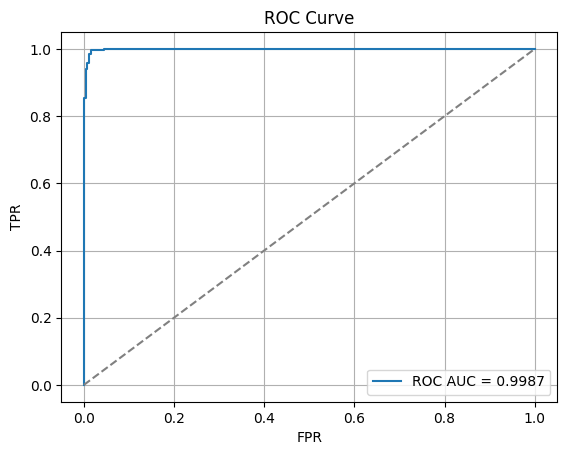

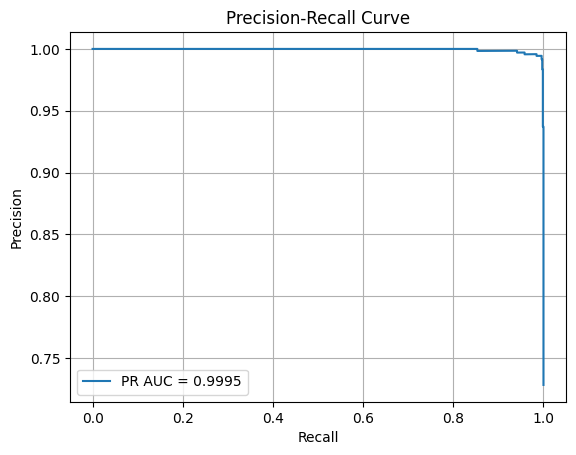

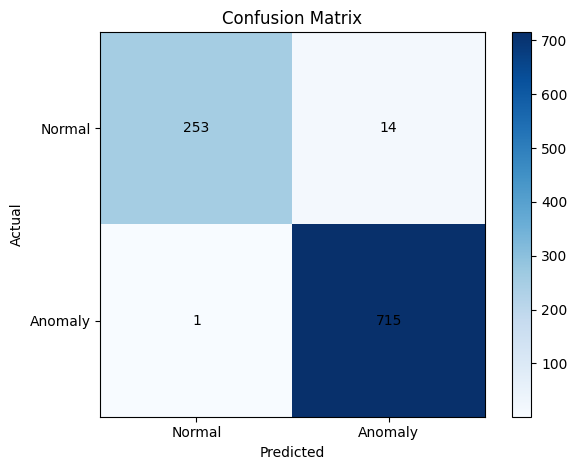

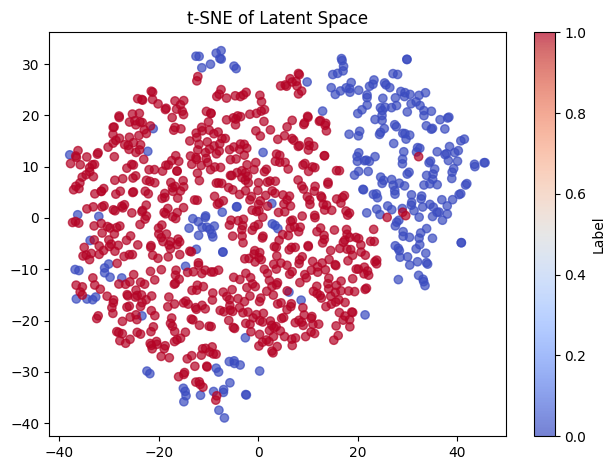

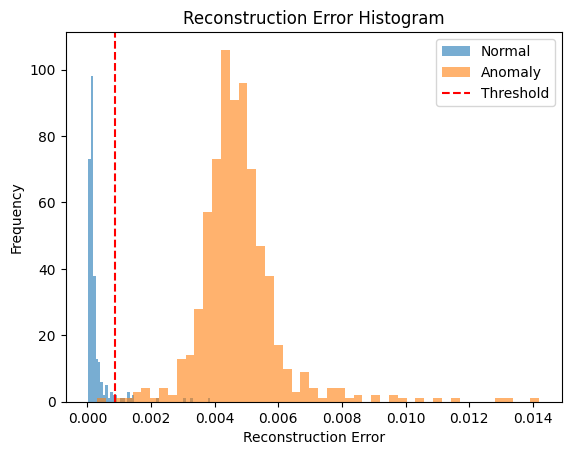

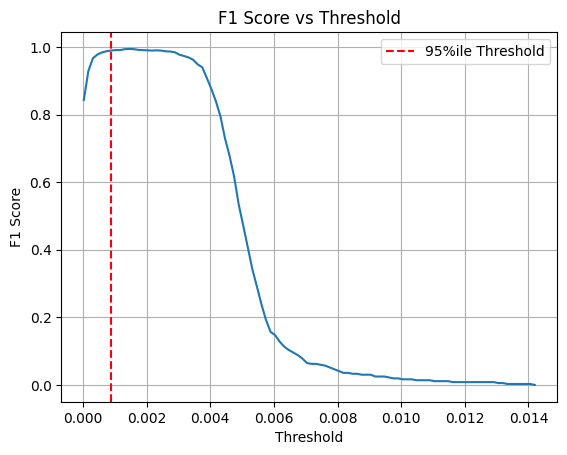

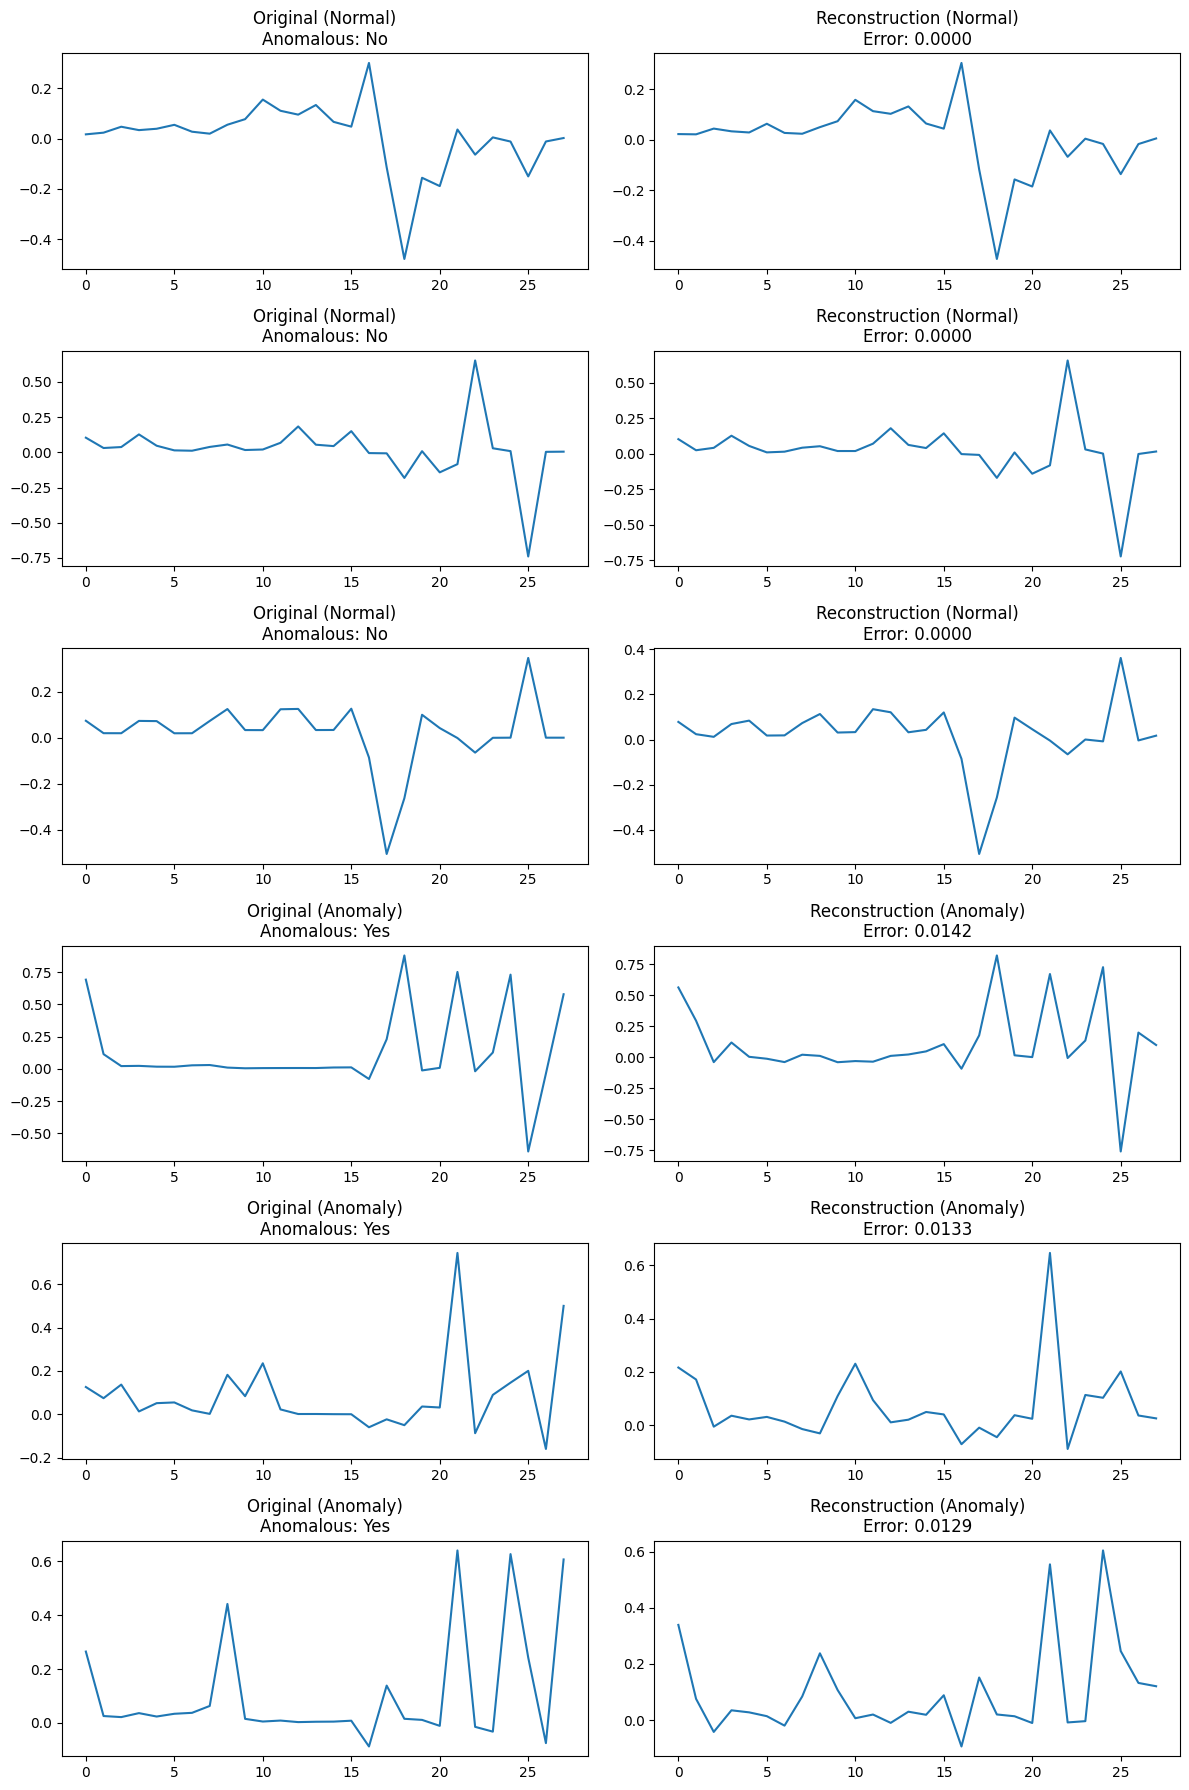

In [16]:
errors, labels, latents, inputs, recons = evaluate_autoencoder(model, test_loader)

classical_metrics = plot_all_metrics(errors, labels, latents, inputs, recons, training_time)

In [17]:
# def compute_metrics(errors, labels):
#     threshold = np.percentile(errors[labels==0], 95)
#     preds = (errors > threshold).astype(int)
#     roc_auc = roc_auc_score(labels, errors)
#     pr_auc = average_precision_score(labels, errors)
#     f1 = f1_score(labels, preds)
#     prec = precision_score(labels, preds)
#     rec = recall_score(labels, preds)
#     return roc_auc, pr_auc, f1, prec, rec


# from itertools import product

# train_dataset, test_dataset = load_data()
# input_dim = train_dataset[0][0].shape[0]
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# encoder_dims = [input_dim//2, input_dim, input_dim*2, 64, 128]
# decoder_dims = [input_dim//2, input_dim, input_dim*2, 64, 128]
# latent_dims = [4, 8, 16, 32, 64]

# best_score = -1
# best_model = None
# best_outputs = None
# best_config = None

# for enc_dim, dec_dim, lat_dim in product(encoder_dims, decoder_dims, latent_dims):
#     print(f"Trying: ENC={enc_dim}, DEC={dec_dim}, LAT={lat_dim}")
#     model = Autoencoder(input_dim, enc_dim, dec_dim, lat_dim).to(DEVICE)
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)
#     loss_fn = nn.MSELoss()
#     start = time.time()
#     train_autoencoder(model, train_loader, optimizer, loss_fn, printing=False)
#     tot = time.time() - start
#     errors, labels, latents, inputs, recons = evaluate_autoencoder(model, test_loader)
#     roc_auc, pr_auc, f1, prec, rec = compute_metrics(errors, labels)
#     score = (roc_auc + pr_auc + f1 + prec + rec) / 5

#     print(f"Score: {score:.4f}\n")

#     if score > best_score:
#         best_score = score
#         best_model = model
#         best_outputs = (errors, labels, latents, inputs, recons)
#         best_config = (enc_dim, dec_dim, lat_dim)

# print(f"\nBest Config → ENC={best_config[0]}, DEC={best_config[1]}, LAT={best_config[2]}")
# print(f"Best Avg Score: {best_score:.4f}")
# plot_all_metrics(*best_outputs, tot)

## Hybrid Quantum-Classical Autoencoder

```
Input (classical)
   ↓
Classical Encoder (Linear layers)
   ↓
Quantum Circuit (QNode with embeddings + entanglers)   : Non-Linear Encoder
   ↓
Classical Decoder (Linear layers)
   ↓
Reconstruction
```

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

import pennylane as qml
from pennylane import numpy as pnp

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


Model

In [19]:
# Classical Layer
INPUT_DIM = train_dataset[0][0].shape[0]
ENCODER_DIM = INPUT_DIM//2 
DECODER_DIM = INPUT_DIM*4
LATENT_DIM =  INPUT_DIM//8 # match number of qubits

print(f"INPUT_DIM: {INPUT_DIM} -> ENCODER_DIM: {ENCODER_DIM} -> LATENT_DIM: {LATENT_DIM} -> DECODER_DIM: {DECODER_DIM}")

EPOCHS = 64

INPUT_DIM: 28 -> ENCODER_DIM: 14 -> LATENT_DIM: 3 -> DECODER_DIM: 112


In [20]:
# Quantum Layer
N_LAYERS = 2
NUM_QUBITS = LATENT_DIM
qlayer_dev = qml.device("lightning.qubit", wires=NUM_QUBITS)

print(f"Quantum Layers: {N_LAYERS}\nQubits: {NUM_QUBITS}")

Quantum Layers: 2
Qubits: 3


Classical ML --encoding--> compressed or transformed format

QuML --Quantum encoding--> quantum state by using quantum gates

In [21]:
@qml.qnode(qlayer_dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(NUM_QUBITS))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(NUM_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(NUM_QUBITS)]

class QuantumEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (N_LAYERS, NUM_QUBITS, 3)}
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        
    def forward(self, x):
        return self.q_layer(x)

# # Classical-Quantum Autoencoder
# class CQAutoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pre_encoder = nn.Sequential(
#             nn.Linear(INPUT_DIM, NUM_QUBITS),
#             # nn.Tanh()
#         )
#         self.quantum_encoder = QuantumEncoder()
        
#         self.decoder = nn.Sequential(
#             nn.Linear(LATENT_DIM, DECODER_DIM),
#             nn.ReLU(),
#             nn.Linear(DECODER_DIM, INPUT_DIM),
#         )

#     def forward(self, x):
#         x = self.pre_encoder(x)
#         latent = self.quantum_encoder(x) # outputs a classical latent vector | _reduced_ feature map: but will this work better with a quantum decoder as well??? Let me check
#         recon = self.decoder(latent)
#         return recon, latent

class QuantumDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (N_LAYERS, NUM_QUBITS, 3)}
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.post_layer = nn.Sequential(
            nn.Linear(NUM_QUBITS, INPUT_DIM)
        )

    def forward(self, x):
        x = self.q_layer(x)
        return self.post_layer(x)  # Project back to input dim

class CQAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_encoder = nn.Sequential(
            nn.Linear(INPUT_DIM, NUM_QUBITS),
            nn.Tanh()
        )
        self.quantum_encoder = QuantumEncoder()
        self.quantum_decoder = QuantumDecoder()

    def forward(self, x):
        x = self.pre_encoder(x)
        latent = self.quantum_encoder(x)
        recon = self.quantum_decoder(latent)
        return recon, latent


# Training loop
def train_autoencoder(model, dataloader, optimizer, loss_fn):
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            optimizer.zero_grad()
            x_recon, _ = model(x)
            loss = loss_fn(x_recon, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= len(dataloader)
        if not epoch or not (epoch+1)%8: print(f"Epoch {epoch+1} Loss: {loss:.5f}")

In [22]:
# Evaluation
def evaluate_autoencoder(model, dataloader):
    model.eval()
    errors, labels, latents, recons, inputs = [], [], [], [], []
    with torch.no_grad():
        for x, label in dataloader:
            x = x.to(DEVICE)
            x_recon, latent = model(x)
            loss = torch.mean((x - x_recon)**2, dim=1)
            errors.extend(loss.cpu().numpy())
            labels.extend(label.numpy())
            latents.extend(latent.cpu().numpy())
            recons.extend(x_recon.cpu().numpy())
            inputs.extend(x.cpu().numpy())
    return np.array(errors), np.array(labels), np.array(latents), np.array(inputs), np.array(recons)

In [23]:
import time

model = CQAutoencoder().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

start_time = time.time()
train_autoencoder(model, train_loader, optimizer, loss_fn)
training_time = time.time() - start_time

Epoch 1 Loss: 0.11364
Epoch 8 Loss: 0.05079
Epoch 16 Loss: 0.03821
Epoch 24 Loss: 0.04819
Epoch 32 Loss: 0.03286
Epoch 40 Loss: 0.01780
Epoch 48 Loss: 0.02862
Epoch 56 Loss: 0.02575
Epoch 64 Loss: 0.02480


ROC AUC Score: 0.6241
PR AUC Score:  0.7728
F1 Score:      0.5232
Precision:     0.7790
Recall:        0.3939
Training Time: 3330.9553


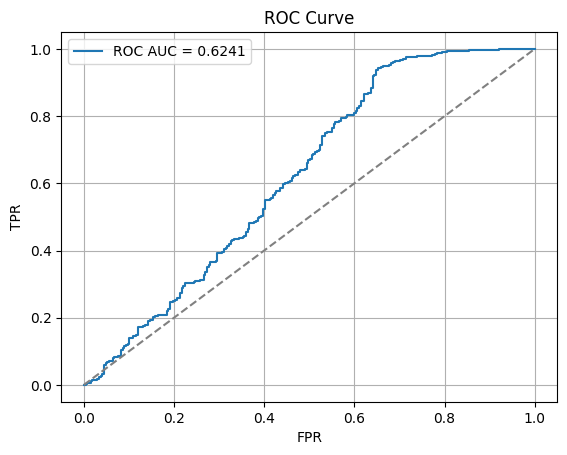

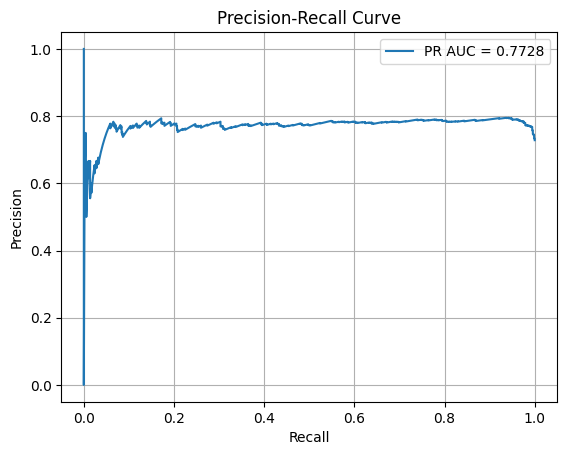

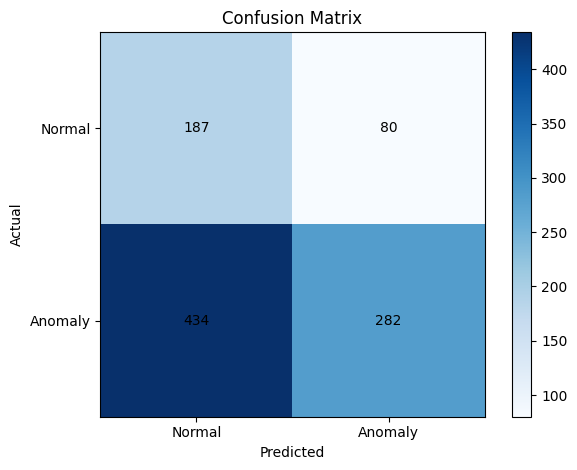

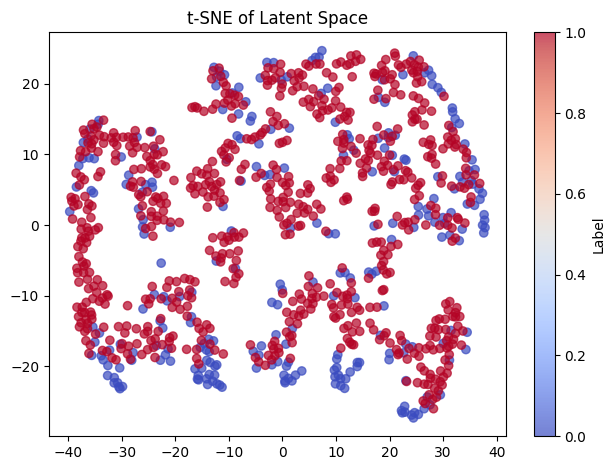

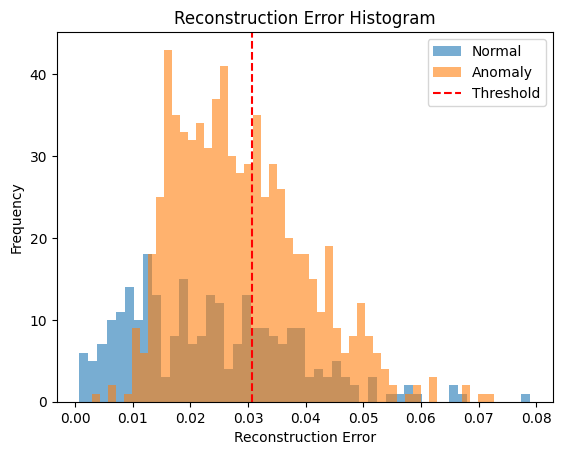

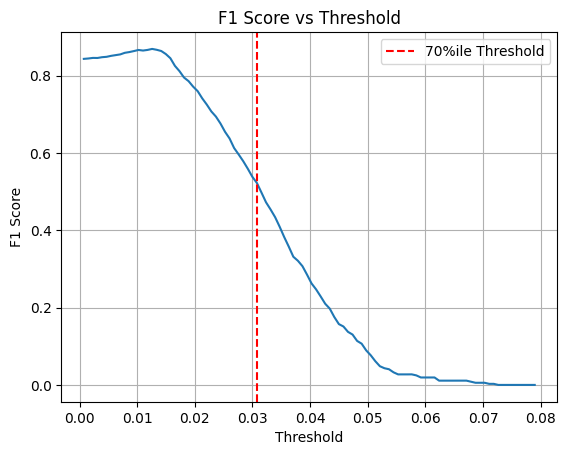

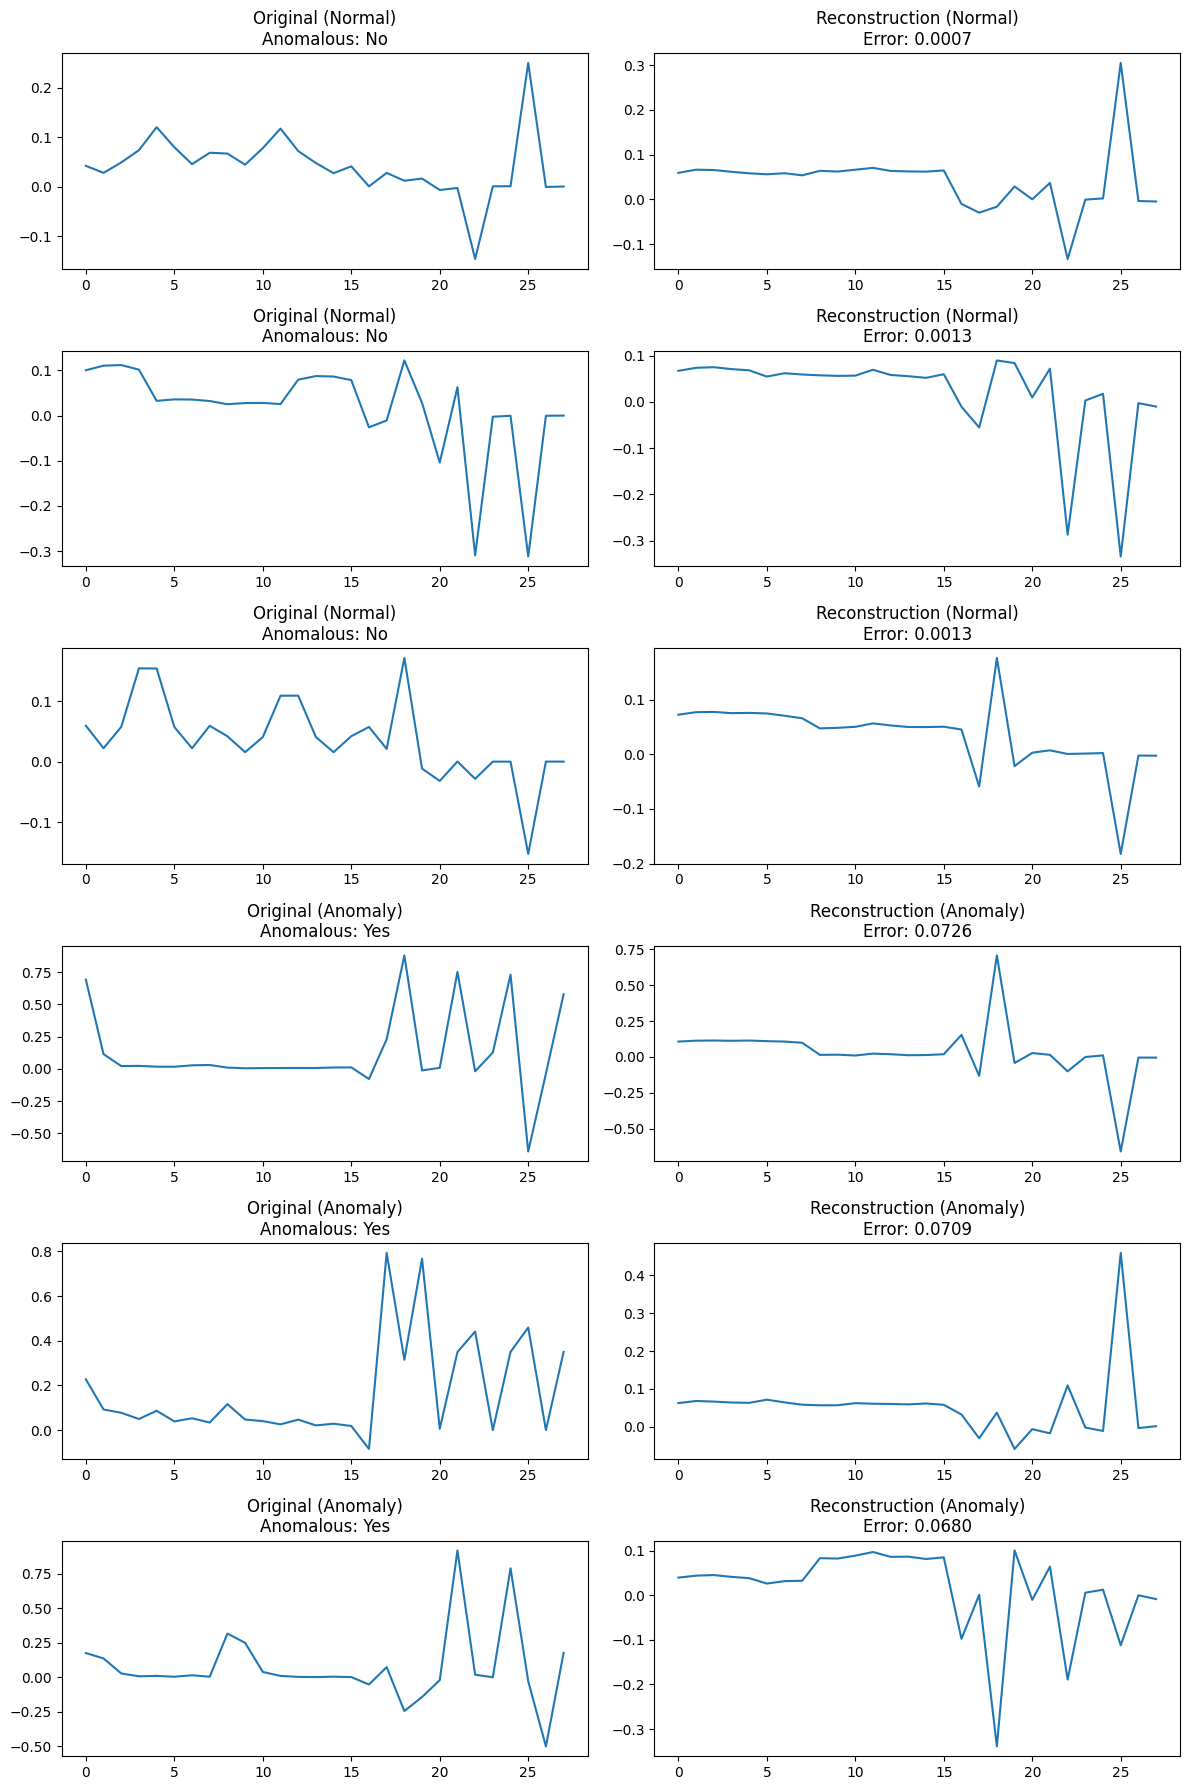

In [24]:
errors, labels, latents, inputs, recons = evaluate_autoencoder(model, test_loader)
hybrid_metrics = plot_all_metrics(errors, labels, latents, inputs, recons, training_time, percentile=70)

UPDATE: Nah not better with Quantum Decoder, I think it actually got worse??? Perhaps look into data normalisation for the decoder as well but I don't see that increasing the performance by any factor that would matter.

As we can see t-SNE does not show separablity. Also, all metrics indicate this does a pretty bad job because:

- Too Few Qubits | Classical -> much wider => Latent expressivity much lower, as you can see normal samples were also not regenerated properly

- Quantum Layer is shallow (2-4 layers) -> low feature extraction

Also, Pennylane does not scale well

So, if the circuit is too shallow, too simple, it can't extract the useful features

FIX: Try different Ansatz (EDIT: tried hadamard, makes it worse in shallow circuits), pre-train classical layers and freeze, Play with optimisation and training

## Quantum Autoencoder: Doesn't work, too slow

```
Input (amplitude-encoded quantum state)
   ↓
Quantum Circuit (rotation + entanglement)
   ↓
Keep "latent" qubits, discard "trash" qubits
   ↓
Measure trash qubits -> should be |0⟩ to represent total disentanglement

```

The quantum autoencoder tries to compress a quantum state, meaning:
- Learn a circuit U(θ) such that:
    - The important information is kept in a few “latent” qubits

    - The trash qubits are disentangled and ideally return to the |0⟩ state; if not -> anomaly. Optionally, reconstruction can be done by inverse(U) or $U^\dagger$

- After learning, the input quantum state becomes: |ψ⟩ = |latent⟩ ⊗ |0...0⟩

| Component        | Hybrid QAE (HQAE)                     | Fully Quantum AE (QAE)                     |
| ---------------- | ------------------------------------- | ------------------------------------------ |
| **Encoder**      | Classical -> Quantum -> Latent        | Quantum circuit encodes + compresses       |
| **Decoder**      | Latent -> Classical Neural Decoder    | Implicit (via measurement of trash qubits) |
| **Latent Space** | Classical latent vector               | Quantum measurement of selected qubits     |
| **Loss**         | MSE between input and reconstruction  | Distance of trash qubits from \|0⟩ state   |
| **Use Case**     | Quantum-enhanced ML on classical data | Compress quantum information               |

# Comparison 

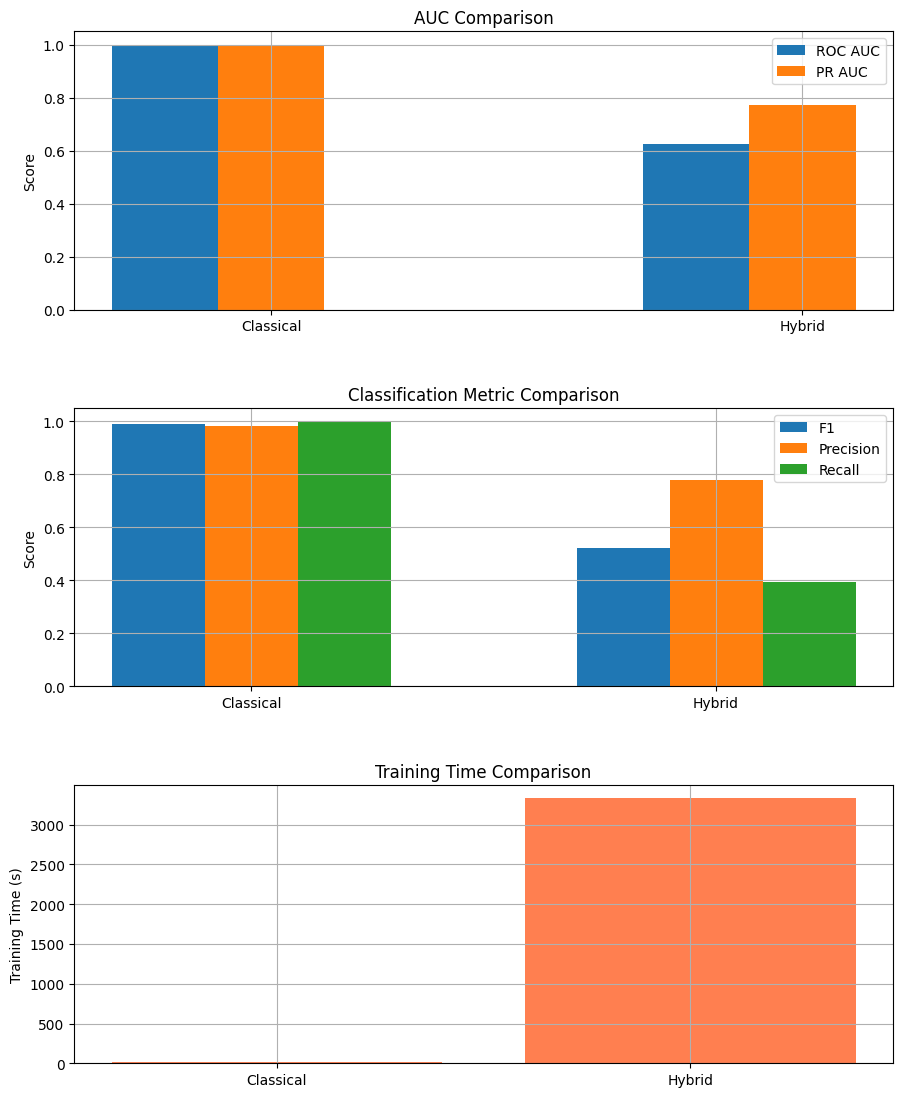

In [25]:
models = ["Classical", "Hybrid"]
roc_auc_scores = [classical_metrics["roc_auc"], hybrid_metrics["roc_auc"]]
pr_auc_scores  = [classical_metrics["pr_auc"], hybrid_metrics["pr_auc"]]
f1_scores      = [classical_metrics["f1"], hybrid_metrics["f1"]]
precision_scores = [classical_metrics["precision"], hybrid_metrics["precision"]]
recall_scores  = [classical_metrics["recall"], hybrid_metrics["recall"]]
training_times = [classical_metrics["training_time"], hybrid_metrics["training_time"]]


x = np.arange(len(models))
width = 0.2
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
fig.tight_layout(pad=5.0)

# Performance metrics (AUC)
axs[0].bar(x - width, roc_auc_scores, width, label='ROC AUC')
axs[0].bar(x, pr_auc_scores, width, label='PR AUC')
axs[0].set_ylabel("Score")
axs[0].set_title("AUC Comparison")
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].legend()
axs[0].grid(True)

# F1, Precision, Recall
axs[1].bar(x - width, f1_scores, width, label='F1')
axs[1].bar(x, precision_scores, width, label='Precision')
axs[1].bar(x + width, recall_scores, width, label='Recall')
axs[1].set_ylabel("Score")
axs[1].set_title("Classification Metric Comparison")
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].legend()
axs[1].grid(True)

# Training Time
axs[2].bar(models, training_times, color='coral')
axs[2].set_ylabel("Training Time (s)")
axs[2].set_title("Training Time Comparison")
axs[2].grid(True)

plt.show()

These timings are for a system under load (trust me it couldnt be more overworked). Actual timings for both classical and hybrid models will be somehat lower at ~80% of this, perhaps slightly lesser for the hybrid one. But the fact still remains that quantum layers have a huge computational cost on simulators and nonquantum-native hardware.